# Candidate Test 2022 Analysis Part 1

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2).

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:
- Age of the candidates grouped by parties.
- An overview of the most "confident" candidates, i.e., those with the highest proportion of "strongly agree" or "strongly disagree" responses.
- Differences in responses between candidates, both inter-party and intra-party, along with an explanation of which parties have the most internal disagreements.
- Classification models to predict candidates' party affiliations. Investigate if there are any candidates who seem to be in the "wrong" party based on their political landscape positions. You must use the following three algorithms: **Decision Tree, Random Forrest, and Gradient Boosted Tree**, and **two other** classification algorithms of your choice.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



## Data preparation
In this section we are preparing the data to be worked on.
But also cleaning up some of the names of columns and the sorting, which should help to make the data more readable.

In [2]:
import pandas as pd
import sklearn as sk

# Utility function - Rename the columns to be more descriptive
def rename_columns(data : pd.DataFrame) -> pd.DataFrame:
    # ? Renaming the columns for the TV2 answers.
    # So the names are easier to understand and work with.
    tv2_original_columns = ['1a','1b','2a','2b','3a','3b','4a','4b',
                            '5a','5b','6a','6b','7a','7b','8a','8b',
                            '9a','9b','10a','10b','11a','11b','12a','12b']
    tv2_new_columns = ['TV2-1a','TV2-1b','TV2-2a','TV2-2b','TV2-3a','TV2-3b','TV2-4a','TV2-4b',
                       'TV2-5a','TV2-5b','TV2-6a','TV2-6b','TV2-7a','TV2-7b','TV2-8a','TV2-8b',
                       'TV2-9a','TV2-9b','TV2-10a','TV2-10b','TV2-11a','TV2-11b','TV2-12a','TV2-12b']
    
    # ? Renaming the columns for the DR answers.
    # So the names are easier to understand and work with.
    dr_orignal_columns = ['530','531','533','534','535','537','538','540','541','543','544','545','546','547','548',
                          '550','551','552','553','555','556','557','559','561','563']
    
    dr_new_columns =  ['DR-1','DR-2','DR-3','DR-4','DR-5','DR-6','DR-7','DR-8','DR-9','DR-10','DR-11','DR-12','DR-13','DR-14','DR-15',
                       'DR-16','DR-17','DR-18','DR-19','DR-20','DR-21','DR-22','DR-23','DR-24','DR-25']

    other_columns_original = ['navn','alder','parti','storkreds']
    other_columns_new = ['Name','Age','Party','District']

    # ! Renaming the actual columns
    data.rename(columns=dict(zip(tv2_original_columns, tv2_new_columns)), inplace=True)
    data.rename(columns=dict(zip(dr_orignal_columns, dr_new_columns)), inplace=True)
    data.rename(columns=dict(zip(other_columns_original, other_columns_new)), inplace=True)
    return data

# Utility function - Set the column order to be more intuitive
def reorder_columns(data : pd.DataFrame) -> pd.DataFrame:
    # ? Reordering the columns
    # So the columns are easier to understand and work with.
    strict_column_order = ['Name','Age','Party','District'];
    remaining_columns = [col for col in data.columns if col not in strict_column_order]
    data = data[strict_column_order + remaining_columns]
    return data

# - Load the raw data from the file 'alldata.xlsx' into a pandas dataframe.
raw_data = pd.read_excel('alldata.xlsx')

# * Create a DataFrame
raw_dataFrame = pd.DataFrame(raw_data)

# ! Renaming the columns
clean_data = rename_columns(raw_dataFrame)

# ! Reordering the columns
clean_data = reorder_columns(raw_dataFrame)

# ? Cleaning party names
clean_data['Party'] = clean_data['Party'].replace('Frie Grønne, Danmarks Nye Venstrefløjsparti', 'Frie Grønne')


# * Preview the cleaned DataFrame
preview_dataFrame = clean_data.head(5)
preview_dataFrame = preview_dataFrame.style.set_caption('Preview of the cleaned DataFrame.')
preview_dataFrame = preview_dataFrame.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
preview_dataFrame = preview_dataFrame.set_properties(**{'text-align': 'center'})

display(preview_dataFrame.hide())

C:\Users\madsh\AppData\Local\Temp\ipykernel_16856\2282627639.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Name,Age,Party,District,DR-1,DR-2,DR-3,DR-4,DR-5,DR-6,DR-7,DR-8,DR-9,DR-10,DR-11,DR-12,DR-13,DR-14,DR-15,DR-16,DR-17,DR-18,DR-19,DR-20,DR-21,DR-22,DR-23,DR-24,DR-25,TV2-1a,TV2-1b,TV2-2a,TV2-2b,TV2-3a,TV2-3b,TV2-4a,TV2-4b,TV2-5a,TV2-5b,TV2-6a,TV2-6b,TV2-7a,TV2-7b,TV2-8a,TV2-8b,TV2-9a,TV2-9b,TV2-10a,TV2-10b,TV2-11a,TV2-11b,TV2-12a,TV2-12b
Lars Philipsen Prahm,78,Moderaterne,Københavns Storkreds,-1,-2,1,-2,2,1,-2,1,1,2,-2,1,2,2,1,-2,1,2,-2,2,2,1,2,2,-2,0,0,2,2,2,-2,-1,0,-1,1,-1,1,2,2,1,0,2,0,1,-2,-2,1,1,1
Karsten Hønge,64,Socialistisk Folkeparti,Fyns Storkreds,2,2,-1,-2,-1,-2,1,-2,2,-2,2,-1,-2,-2,2,2,-2,1,1,-1,-2,1,2,1,2,1,1,1,1,1,2,2,2,-2,0,1,-2,-2,0,0,0,-2,0,-1,2,1,-2,0,0
Martin Kelleher-Petersen,37,Alternativet,Bornholms Storkreds,2,1,-2,-2,1,-2,1,-1,1,-1,2,-2,-2,-1,1,1,-2,2,-1,-2,-1,1,2,2,2,1,1,1,2,1,1,2,0,-1,1,2,-2,-2,-2,1,1,-1,-2,0,2,0,-1,1,-2
Nicklas Gjedsig Larsen,28,Alternativet,Nordjyllands Storkreds,2,1,-2,-1,1,1,1,1,1,-2,2,1,1,-2,2,2,-2,2,1,2,-2,2,2,2,2,2,2,2,2,0,2,0,2,-2,2,-1,2,0,-2,2,2,-2,2,2,2,2,-1,2,0
Tom Gillesberg,58,Løsgænger,Københavns Storkreds,1,1,-2,2,-2,1,-2,1,2,-2,-2,2,2,-2,2,1,-2,2,-2,-2,-1,1,-2,-1,-2,-2,-2,0,0,-2,-2,2,1,-2,2,1,-2,2,-2,1,0,-2,0,-1,0,-2,0,2,-2


## Age distribution with the different parties

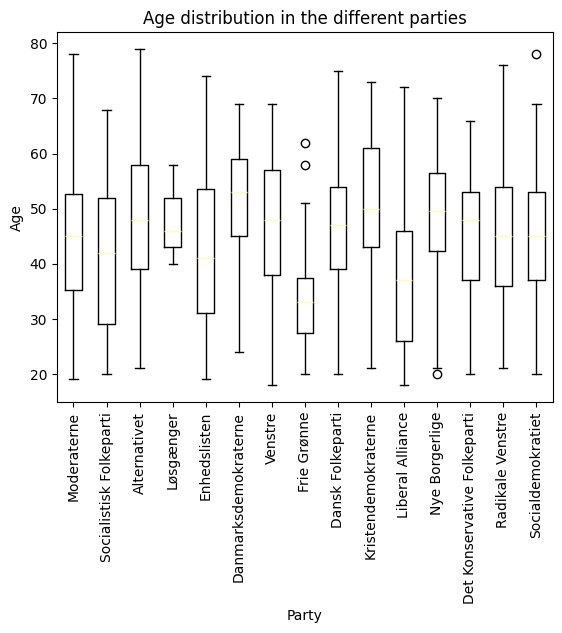

In [3]:
import matplotlib.pyplot as plot

filtered_data = clean_data[clean_data['Age'] != 0]

# - Fetch the necessary data 
ages = filtered_data['Age']
parties = filtered_data['Party']

# * Initialize the empty dictionary
party_ages = {}

# * Iterate through the data and populate the dictionary
for index, row in filtered_data.iterrows():
    party = row['Party']
    age = row['Age']
    if party in party_ages:
        party_ages[party].append(age)
    else:
        party_ages[party] = [age]


# * Extract the data from the dictionary
party_names = list(party_ages.keys())
party_ages = list(party_ages.values())

# * Plot the data
plot.boxplot(party_ages, labels=party_names)

# ? Style the plot
plot.style.use('dark_background')
plot.xticks(range(1, len(party_names) + 1), party_names, rotation=90)
plot.title('Age distribution in the different parties')
plot.xlabel('Party')
plot.ylabel('Age')

# - Display the plot
plot.show()


## Overview on the most "Confident" candiates
*I.E - Those with the highest proportion of "strongly agree" or "strongly disagree"*

Firstly we are going to gain all the insight on the different candicates answer distribution.
Afterwards we are going to look for the last distribution with in the 'Strongly Agree' and 'Strongly Disagree' columns

In [4]:

# - Fetch the necessary data
selected_data = clean_data[['Name', 'Party'] + [col for col in clean_data.columns if 'DR' in col or 'TV2' in col]]
responses = [col for col in selected_data.columns if 'DR' in col or 'TV2' in col]

# * Initialize the empty dictionary
candidate_answers = {}

# ! Iterate through the data and populate the dictionary
for index, row in selected_data.iterrows():
    # * Extract the candidate's name

    # * Initialize the empty dictionary
    candidate_answers[index] = {
        'Name' : row['Name'],
        'Party' : row['Party'],
        'Strongly Agree': 0,
        'Agree': 0,
        'Neutral': 0,
        'Disagree': 0,
        'Strongly Disagree': 0,
    }

    # ! Iterate through the answers and populate the dictionary
    for response in responses:
        # * Extract the response
        value = row[response]

        # ? Update the dictionary based on the response
        if value == 2:
            candidate_answers[index]['Strongly Agree'] += 1
        elif value == 1:
            candidate_answers[index]['Agree'] += 1
        elif value == 0:
            candidate_answers[index]['Neutral'] += 1
        elif value == -1:
            candidate_answers[index]['Disagree'] += 1
        elif value == -2:
            candidate_answers[index]['Strongly Disagree'] += 1

# - Make a DataFrame from the dictionary
candidate_answers = pd.DataFrame(candidate_answers).T

# * Convert the counts to numeric for counts
candidate_answers['Strongly Agree'] = pd.to_numeric(candidate_answers['Strongly Agree'])
candidate_answers['Agree'] = pd.to_numeric(candidate_answers['Agree'])
candidate_answers['Neutral'] = pd.to_numeric(candidate_answers['Neutral'])
candidate_answers['Disagree'] = pd.to_numeric(candidate_answers['Disagree'])
candidate_answers['Strongly Disagree'] = pd.to_numeric(candidate_answers['Strongly Disagree'])

# ? Style the DataFrame
preview_answers = candidate_answers.head(10).style.set_caption('Preview of the candidate answers.')
preview_answers = preview_answers.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
preview_answers = preview_answers.set_properties(**{'text-align': 'center'})

# * Preview the DataFrame
display(preview_answers.hide())




Name,Party,Strongly Agree,Agree,Neutral,Disagree,Strongly Disagree
Lars Philipsen Prahm,Moderaterne,15,15,5,4,10
Karsten Hønge,Socialistisk Folkeparti,12,12,7,5,13
Martin Kelleher-Petersen,Alternativet,10,16,3,8,12
Nicklas Gjedsig Larsen,Alternativet,25,9,4,3,8
Tom Gillesberg,Løsgænger,10,9,6,3,21
Jan Kristoffersen,Alternativet,10,15,4,14,6
Johan Kahl,Moderaterne,12,17,3,11,6
Thor Clasen Jonasen,Alternativet,17,10,1,10,11
Chresten H. Ibsen,Løsgænger,11,14,5,13,6
Vinni Kjærgaard Jørgensen,Alternativet,12,12,7,3,15


### Top 5 - Candidates with the most strongly combined answers

In [5]:
# # Top 5 strongly combined

# * Create a copy of the DataFrame
# So we can modify it without affecting the original
modified_candidate_answers = candidate_answers.copy()

# * Add a new column to the DataFrame
# That contains the sum of the 'Strongly Agree' and 'Strongly Disagree' columns
modified_candidate_answers['Strongly Combined'] = modified_candidate_answers['Strongly Agree'] + modified_candidate_answers['Strongly Disagree']

# * Sort the DataFrame by the new column in descending order
# And only display the top 5
top_5_strongly_combined = modified_candidate_answers.sort_values('Strongly Combined', ascending=False).head(5)

# ? Style the DataFrame
top_5_strongly_combined = top_5_strongly_combined.style.set_caption('Top 5 candidates with the most strongly combined answers.')
top_5_strongly_combined = top_5_strongly_combined.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
top_5_strongly_combined = top_5_strongly_combined.set_properties(**{'text-align': 'center'})

# - Display the DataFrame
display(top_5_strongly_combined.hide())

Name,Party,Strongly Agree,Agree,Neutral,Disagree,Strongly Disagree,Strongly Combined
Sarah Nørris,Enhedslisten,24,0,0,0,25,49
Søren Vanting,Det Konservative Folkeparti,18,0,0,0,31,49
Kim Andkjær Doberck,Nye Borgerlige,22,0,4,1,22,44
Rashid Ali,Frie Grønne,23,3,2,1,20,43
Mohamed Abdikarim,Frie Grønne,21,1,0,5,22,43


So we can conclude that the most confident candidates are Sarah Nørris and Søren Vanting, since the have the must "Strongly" answers for all the questions combined.

### Top 5 - Candidates with the most strongly agree answers

In [6]:

# # Top 5 strongly agree

# * Sort the DataFrame by the 'Strongly Agree' column in descending order
# And only display the top 5
top_5_strongly_agree = candidate_answers.sort_values(by='Strongly Agree', ascending=False).head(5)

# ? Style the DataFrame
top_5_strongly_agree = top_5_strongly_agree.style.set_caption('Top 5 candidates with the most strongly agree answers.')
top_5_strongly_agree = top_5_strongly_agree.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
top_5_strongly_agree = top_5_strongly_agree.set_properties(**{'text-align': 'center'})

# - Display the DataFrame
display(top_5_strongly_agree.hide())

Name,Party,Strongly Agree,Agree,Neutral,Disagree,Strongly Disagree
Jesper Callesen,Alternativet,25,6,2,6,10
Frank Sørensen,Dansk Folkeparti,25,4,0,3,17
Nicklas Gjedsig Larsen,Alternativet,25,9,4,3,8
Sarah Nørris,Enhedslisten,24,0,0,0,25
Jef Seistrup,Alternativet,24,4,3,2,16


### Top 5 - Candidates with the most strongly disagree answers

In [32]:

# # Top 5 strongly disagree

# * Sort the DataFrame by the 'Strongly Disagree' column in descending order
# And only display the top 5
top_5_strongly_disagree = candidate_answers.nlargest(5, 'Strongly Disagree', keep='all')

# ? Style the DataFrame
top_5_strongly_disagree = top_5_strongly_disagree.style.set_caption('Top 5 candidates with the most strongly disagree answers.')
top_5_strongly_disagree = top_5_strongly_disagree.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
top_5_strongly_disagree = top_5_strongly_disagree.set_properties(**{'text-align': 'center'})

# - Display the DataFrame
display(top_5_strongly_disagree.hide())

Name,Party,Strongly Agree,Agree,Neutral,Disagree,Strongly Disagree
Søren Vanting,Det Konservative Folkeparti,18,0,0,0,31
Sarah Nørris,Enhedslisten,24,0,0,0,25
Steffen Sjørslev,Liberal Alliance,15,4,2,3,25
John Bjerg,Nye Borgerlige,18,3,3,1,24
Thomas Vedsted,Nye Borgerlige,17,4,2,2,24


## Differences in responses between candidates
*In this section we are going to be looking at the difference between the average candidate and each candidates answers.*

*We are also going to be looking at the differences with parties*

### Inter-party
In this segment, we're taking a look at how candidates from different parties don't always have the same opionins. It's interesting to see which questions have them split the most and which they can agree on. 

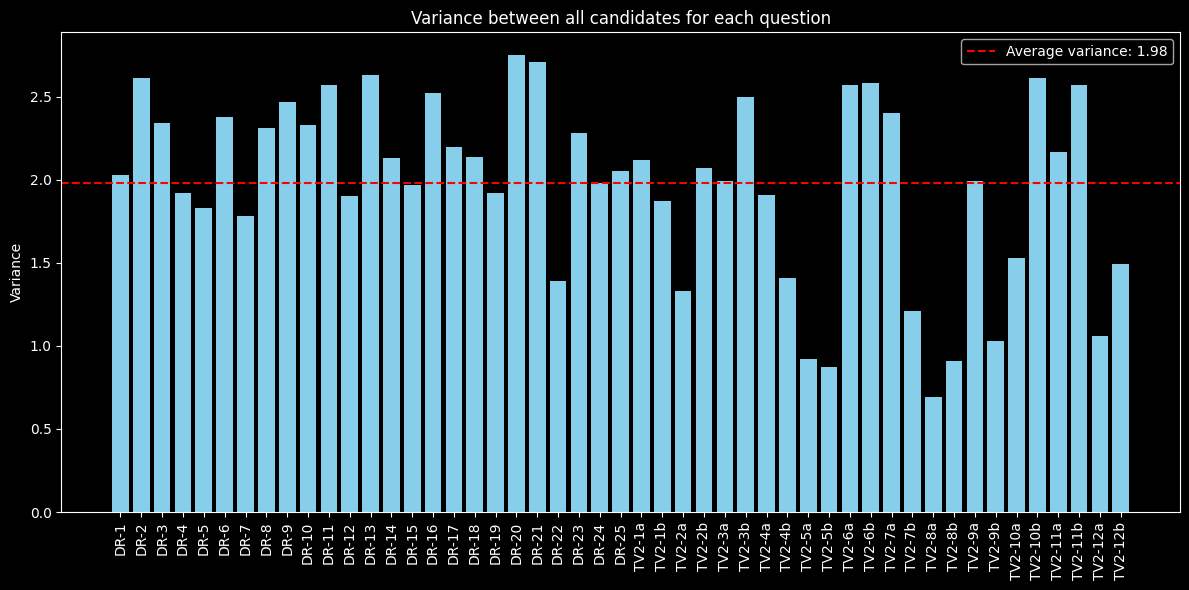

In [8]:
import numpy as np

# - Fetch the necessary data
selected_data = clean_data[['Name', 'Party'] + [col for col in clean_data.columns if 'DR' in col or 'TV2' in col]]

# - Find the questions
responses = [col for col in selected_data.columns if 'DR' in col or 'TV2' in col]

# * Initialize the empty dictionary
data = {}

# ! Iterate through the responses and populate the dictionary
for response in responses:
    # * Calculate the variance for each response
    data[response] = selected_data[response].var()

# - Make a DataFrame from the dictionary
df_var = pd.DataFrame(data , index=[0])

# * Format the variance to be more readable
df_var = df_var.map(lambda x: '{:.2f}'.format(x))

# ? Style the DataFrame
differences_variance = df_var.style.set_caption('Variance of the responses.')
differences_variance = differences_variance.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
differences_variance = differences_variance.set_properties(**{'text-align': 'center'})

# - Display the DataFrame
# display(differences_variance.hide())

# - Create Bar plot
# Transpose the DataFrame
df_var_transposed = df_var.T

# * Convert the variance values from string to float
df_var_transposed[0] = df_var_transposed[0].astype(float)

# * Generate the bar plot
plot.style.use('dark_background')
plot.figure(figsize=(12, 6))  # Set the figure size as desired
plot.bar(df_var_transposed.index, df_var_transposed[0], color='skyblue')  # Plotting

# * Calculate the average and add a line to the plot
average_variance = df_var_transposed[0].mean()
plot.axhline(y=average_variance, color='r', linestyle='--', label=f'Average variance: {average_variance:.2f}')

# ? Style the plot
plot.title('Variance between all candidates for each question')
plot.xticks(rotation=90, ha="center")
plot.ylabel('Variance')
plot.legend()
plot.tight_layout()

# - Display the plot
plot.show()


The diagram above illustrates the variance in responses to different questions. This variance can be interpreted as a measure of agreement or disagreement among the candidates' answers. Higher variance bars suggest a wider range of opinions among the candidates on those particular questions, for instance, `DR-20`. Conversely, questions with lower variances indicate a relative consensus among the candidates e.g. `TV2-5a`

### Intra-party
In this segment, we're going to take a look at how the opionins can differ even within the same party. This should give us a general depiction of how the general consensus is within the different parties.

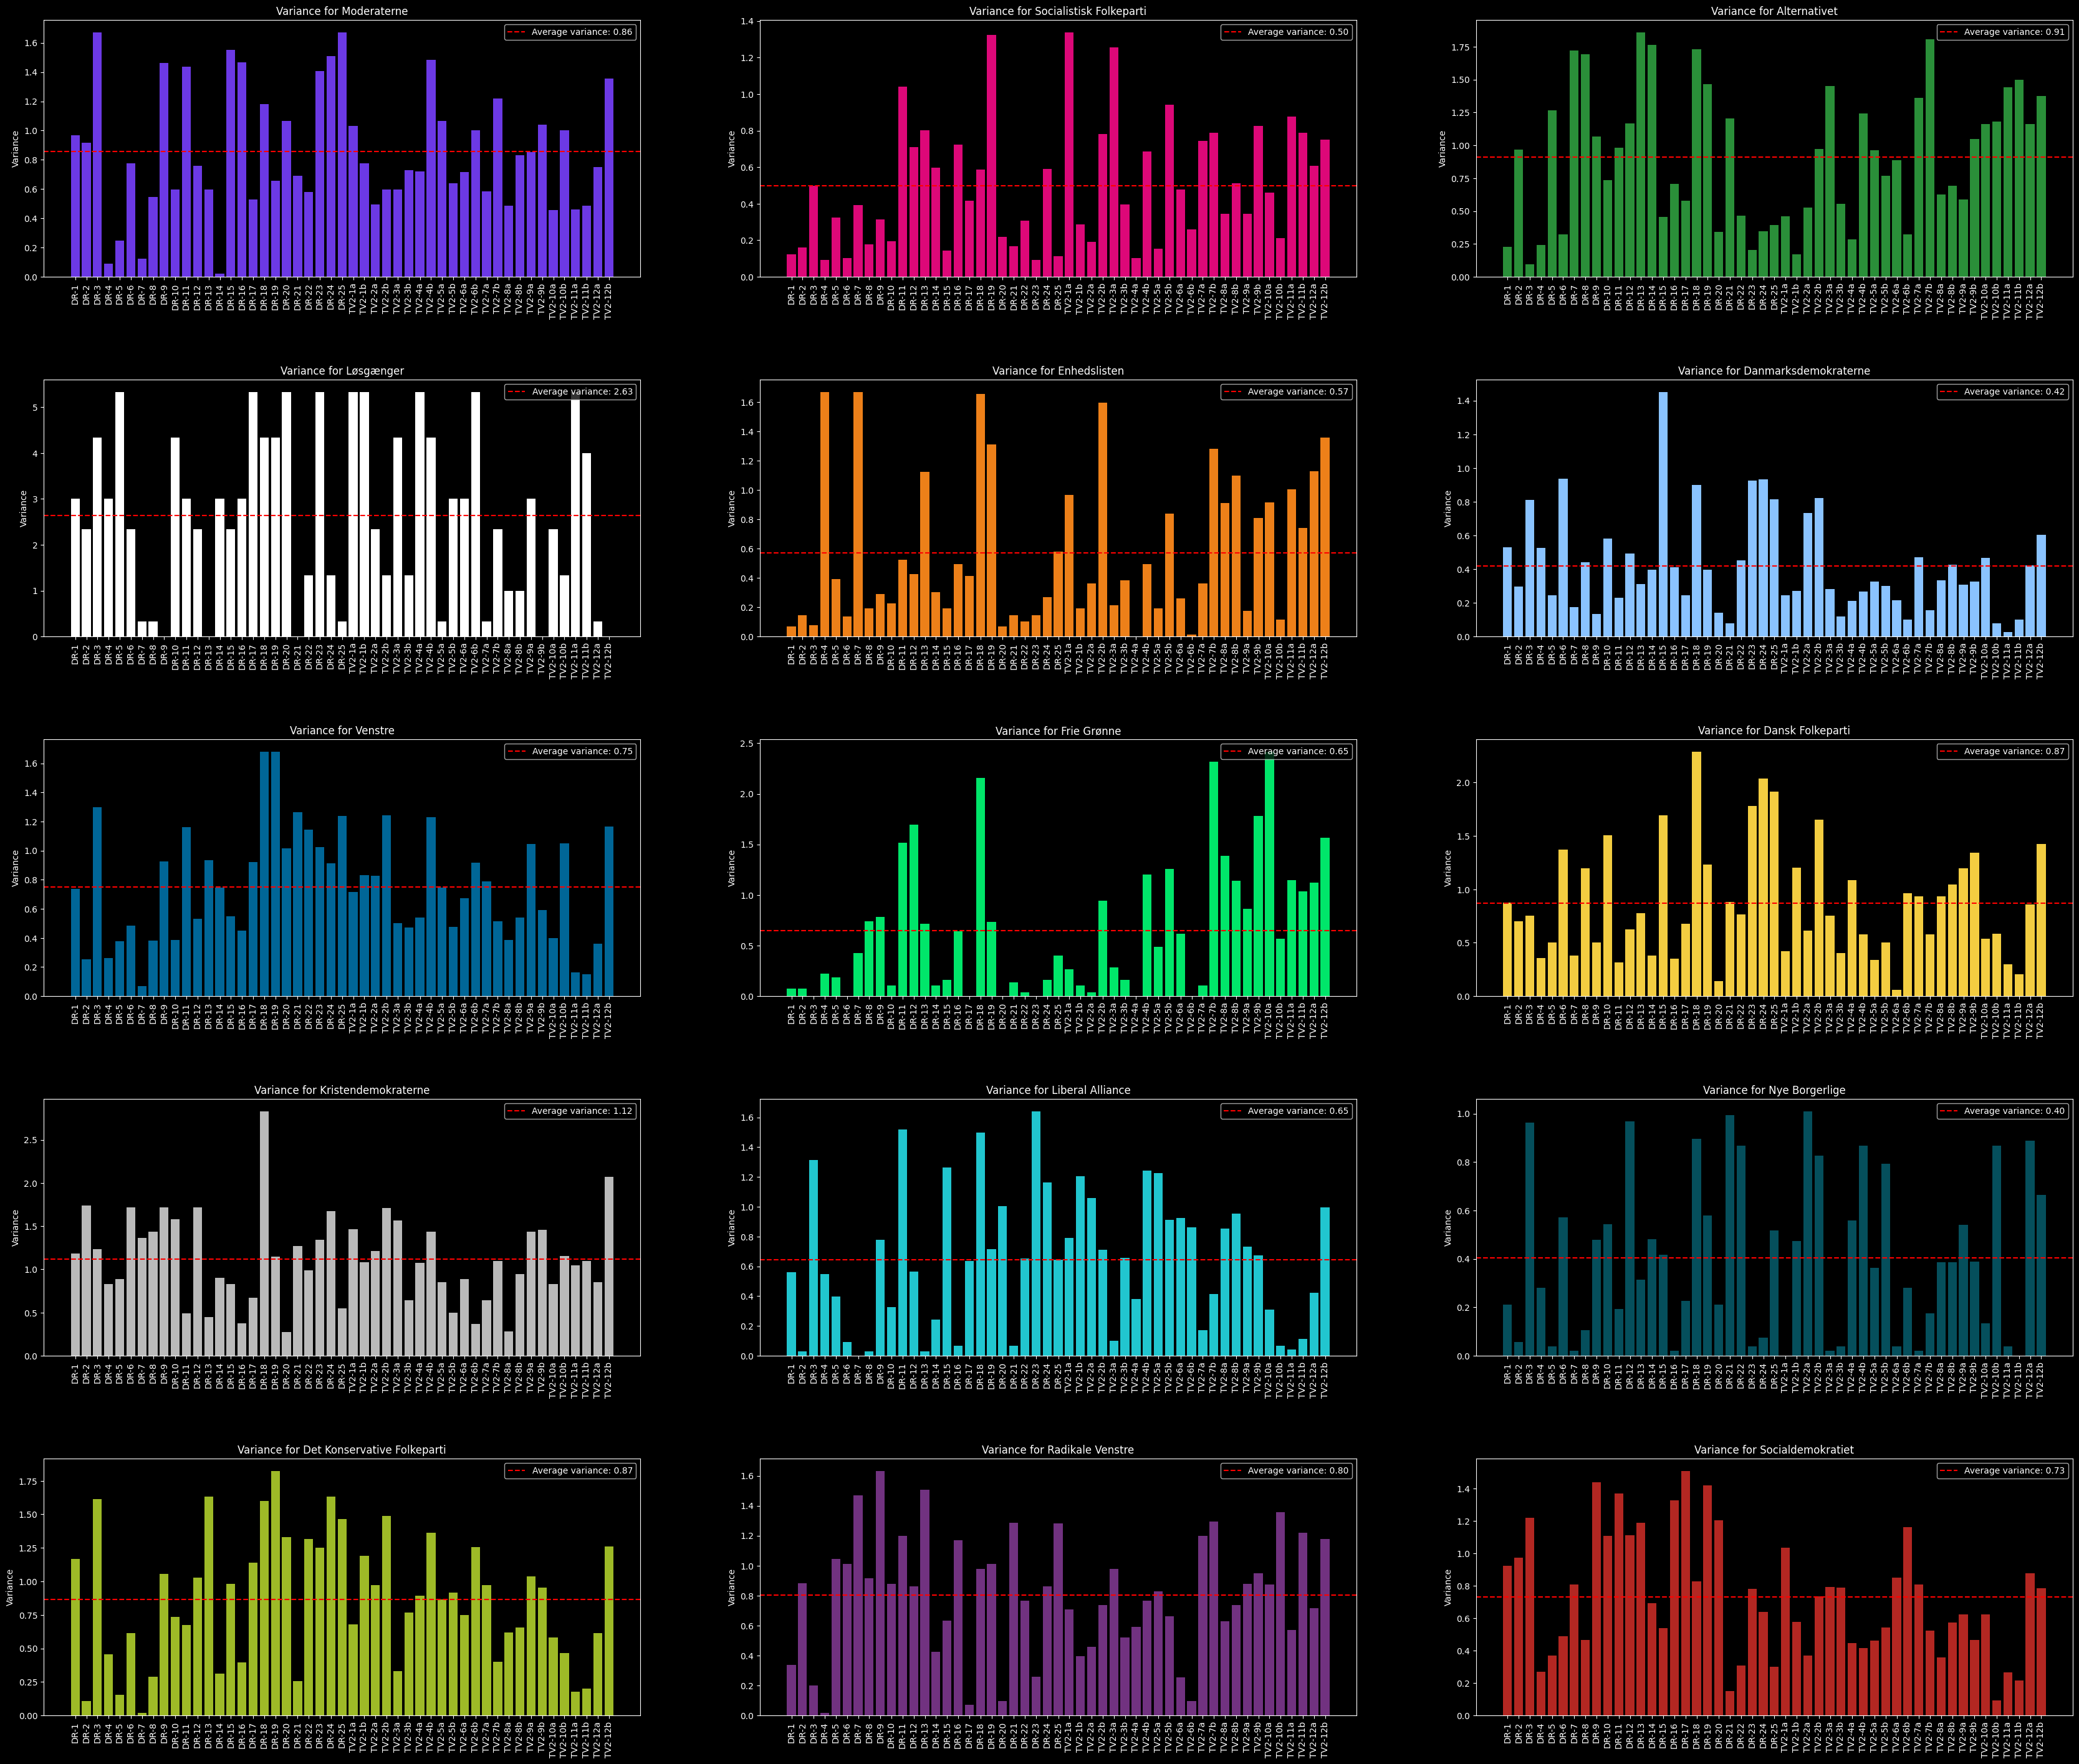

In [9]:
import numpy as np

# Utility function - Colors for the different parties
def party_colors() -> dict:
    return {
        'Moderaterne': '#6c39e5',
        'Socialistisk Folkeparti': '#dd0878',
        'Alternativet': '#2a8f39',
        'Løsgænger': 'white',
        'Enhedslisten': '#ed8019',
        'Danmarksdemokraterne': '#8ac3ff',
        'Venstre': '#006697',
        'Frie Grønne': '#00e66a',
        'Dansk Folkeparti': '#f3cd41',
        'Kristendemokraterne': '#bababa',
        'Liberal Alliance': '#21c6cf',
        'Nye Borgerlige': '#054f5c',
        'Det Konservative Folkeparti': '#9eba27',
        'Radikale Venstre': '#713280',
        'Socialdemokratiet': '#b32722'
    }

# - Fetch the necessary data
selected_data = clean_data[['Name', 'Party'] + [col for col in clean_data.columns if 'DR' in col or 'TV2' in col]]

# - Find the questions
responses = [col for col in selected_data.columns if 'DR' in col or 'TV2' in col]

# - Find the parties
parties = selected_data['Party'].unique()
party_colors = party_colors()

# * Initialize the empty dictionary
data = {}

# ! Iterate through the responses and populate the dictionary
for response in responses:
    # * Calculate the variance for each response
    for party in parties:
        # * Extract the data for the specific party
        party_data = selected_data[selected_data['Party'] == party]

        # * Calculate the variance for the party
        variance = party_data[response].var()

        # ? Update the dictionary
        if party in data:
            data[party][response] = variance
        else:
            data[party] = {response: variance}


# * Calculate the number of rows and columns for the subplots
n_parties = len(parties)
n_cols = 3
n_rows = np.ceil(n_parties / n_cols).astype(int)

# * Create the subplots
plot.style.use('dark_background') 
fig, axs = plot.subplots(n_rows, n_cols, figsize=(14 * n_cols, 8 * n_rows))  # Adjust the figure size as needed

# * Flatten the axis array for easy indexing
axs = axs.flatten()

# ? Iterate through the parties and plot the variance
for idx, party in enumerate(parties):
    df_var = pd.DataFrame(data[party], index=[0])
    df_var_transposed = df_var.T
    df_var_transposed[0] = df_var_transposed[0].astype(float)
    
    # * Plot on the respective subplot
    ax = axs[idx]
    ax.bar(df_var_transposed.index, df_var_transposed[0], color=party_colors[party])
    
    # * Calculate the average and add a line to the plot
    average_variance = df_var_transposed[0].mean()
    ax.axhline(y=average_variance, color='r', linestyle='--', label=f'Average variance: {average_variance:.2f}')
    
    # ? Style the plot
    ax.set_title(f'Variance for {party}')
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('Variance')
    ax.legend(loc="upper right")

# * Hide any unused axes
for idx in range(n_parties, n_rows * n_cols):
    axs[idx].set_visible(False)

# * Adjust layout to prevent overlap
fig.subplots_adjust(bottom=0.2, hspace=0.4)

# - Display the plot
plot.show()



The party with the most internal disagreement is Kristendemokraterne, which is reflected by their highest average variance of 1.12 among all the parties. Following them, Alternativet holds the position of having the second most internal disagreement, with a variance of 0.92. While some might argue that Løsgænger exhibits a higher variance, at 2.63, it's important to note that Løsgænger is not considered a formal party. Given that it consists of only three members, their political opinions do not necessarily need to align. Therefore, for the purpose of this analysis, they are not included in the comparison of formal parties.

## Classification models to predict candidates' party affiliations

### Data preprocessing

In [10]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# - Fetch the necessary data
data = clean_data.copy()

# Utility function - Find the median age for each party as dictionary
def median_age(data : pd.DataFrame) -> dict:
    # * Initialize the empty dictionary
    median_ages = {}

    # ! Iterate through the data and populate the dictionary
    for party in data['Party'].unique():
        # * Extract the data for the specific party
        party_data = data[data['Party'] == party]

        # * Calculate the median age for the party
        median_ages[party] = party_data['Age'].median()

    return median_ages

# ! Impute the missing ages with the median age for the respective party
# So we can use the age in the analysis.
median_ages = median_age(data)
for party, median_age in median_ages.items():
    data.loc[data['Party'] == party, 'Age'].fillna(median_age)

# Utility function - Remove 'Løsgænger' from the data
def remove_losgaenger(data : pd.DataFrame) -> pd.DataFrame:
    return data[data['Party'] != 'Løsgænger']

# ! Remove 'Løsgænger' from the data
# Since it's not a party, we can't predict if a candidate is a 'Løsgænger' or not
data = remove_losgaenger(data)

# ! Remove 'Name' and from the data
# Since it's not a feature that can be used to predict the party
data = data.drop('Name', axis=1)

# - Preparing feature and target variables
X = data.drop('Party', axis=1)
y = data['Party']

# * Encode categorical variables and impute any missing values if necessary
categorical_features = ['District']
numeric_features = X.drop(columns=categorical_features).columns.tolist()

# # Preprocessing for numerical features: no imputation needed beyond age adjustment already done
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# # Preprocessing for categorical features: encode 'storkreds'
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# ! Combine preprocessing for both numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


# - Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Here we are preparing the data to be worked on with the different machine learning algorithms. First off we start by finding the average within the different parties, so we can impute the age which are 0 in the dataset. 
Then we start removing the 'Løsgænger', since they aren't a formal party and therefore you should be able to be affiated with them. And since Name should have an impact on the prediction, we remove it.   

Lastly we setup the `OneHotEncoder` to transform the Distric into a usable column. Additional we setup an `SimpleImputer` to handle the missing fields, which is just gonna insert the median value, if it is empty. Then we combine these in a step we are gonna call `preprocessor`, so we can reuse for the different pipelines for the 5 models.

### Trees

#### Decision Tree

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters: {'classifier__max_depth': 9}
Accuracy on training set: 0.977
Accuracy on test set: 0.775


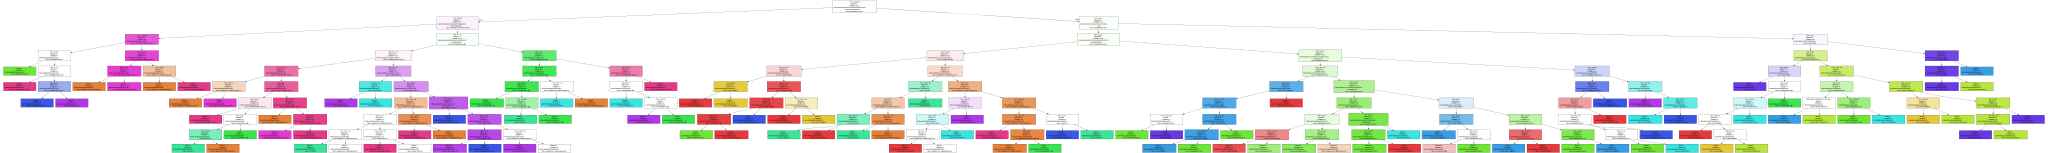

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

# - Create preprocessing and modeling pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', DecisionTreeClassifier(max_depth=9,random_state=42))])

# * Fit the classifier to the training data
model.fit(X_train, y_train)

# Param grid for grid search
param_grid = {
    'classifier__max_depth': [3, 5, 7, 9, 11, 13, 15]
}

# - Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5, verbose=1)
grid_search.fit(X_train, y_train)

# - Print the best parameters
print("Best parameters: {}".format(grid_search.best_params_))

# - Print the accuracy
print("Accuracy on training set: {:.3f}".format(model.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

# - Create a graph of the decision tree
transformed_columns = numeric_features + list(model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out())


# * Extract the tree
tree = model.named_steps['classifier']

# * Export the tree to a dot file
dot_data = export_graphviz(tree, out_file=None, feature_names=transformed_columns, class_names=y_test.unique(), filled=True, special_characters=True)

# * Display the graph
graph = graphviz.Source(dot_data)

# - Display the graph
graph

**Best parameters**: `max_depth` = 9  
**Accuracy** (*Training*): `97.7%`  |   **Accuracy** (*Test*): `77.5%`

#### Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# - Create preprocessing and modeling pipeline
model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(max_depth=12,random_state=42, max_features=10, n_estimators=200))])

# * Fit the classifier to the training data
model.fit(X_train, y_train)

# - Param grid for grid search
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_features': [10, 15, 20],
    'classifier__max_depth': [8, 10, 12]
}

# * Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy")

# * Fit the grid search to the data
grid_search.fit(X_train, y_train)

# * Display the best parameters, best cross-validation score, and test score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# - Print the accuracy
print("Accuracy on training set: {:.3f}".format(model.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Best Parameters: {'classifier__max_depth': 12, 'classifier__max_features': 10, 'classifier__n_estimators': 200}
Best Cross-Validation Score: 0.8929308726931499
Accuracy on training set: 1.000
Accuracy on test set: 0.948


**Best parameters**: `max_depth` = 12 | `max_features` = 10 | `n_estimators` = 200    
**Accuracy** (*Training*): `100.0%`  |   **Accuracy** (*Test*): `94.8%`

#### Gradient Boosted Tree

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# - Create preprocessing and modeling pipeline
model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', GradientBoostingClassifier(max_depth=8,random_state=42, n_estimators=100, learning_rate=0.1))])

# * Fit the classifier to the training data
model.fit(X_train, y_train)

# - Print the accuracy
print("Accuracy on training set: {:.3f}".format(model.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.838


**Best parameters**: `max_depth` = 8 | `n_estimators` = 100 | `learning_rate` = 0.1 | `random_state` = 42    
**Accuracy** (*Training*): `100.0%`  |   **Accuracy** (*Test*): `83.8%`

### Alternative CLassification algoritms

#### Logistic regression

In [26]:
from sklearn.linear_model import LogisticRegression

# - Create preprocessing and modeling pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),('classifier', LogisticRegression(max_iter=10000))])

# * Fit the classifier to the training data
model.fit(X_train, y_train)

# - Param grid for grid search
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__max_iter': [10000, 20000, 30000]
}

# * Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy")

# * Fit the grid search to the data
grid_search.fit(X_train, y_train)

# * Display the best parameters, best cross-validation score, and test score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# - Print the accuracy
print("Accuracy on training set: {:.3f}".format(model.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Best Parameters: {'classifier__C': 0.01, 'classifier__max_iter': 10000}
Best Cross-Validation Score: 0.8943488687311021
Accuracy on training set: 0.994
Accuracy on test set: 0.925


**Best parameters**: `C` = 0.01 | `max_iter` = 10000    
**Accuracy** (*Training*): `99.4%`  |   **Accuracy** (*Test*): `92.5%`

#### KNeighbors

In [30]:
from sklearn.neighbors import KNeighborsClassifier

# - Create preprocessing and modeling pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', KNeighborsClassifier(n_neighbors=5))])

# * Fit the classifier to the training data
model.fit(X_train, y_train)

# - Param grid for grid search
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15]
}

# * Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy")

# * Fit the grid search to the data
grid_search.fit(X_train, y_train)

# * Display the best parameters, best cross-validation score, and test score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

print("Accuracy on training set: {:.3f}".format(model.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Best Parameters: {'classifier__n_neighbors': 5}
Best Cross-Validation Score: 0.7815034928578874
Accuracy on training set: 0.874
Accuracy on test set: 0.844


**Best parameters**: `n_neighbors` = 5   
**Accuracy** (*Training*): `87.4%`  |   **Accuracy** (*Test*): `84.4%`

### Candidates which might be located in the wrong party

In [16]:

# - Create preprocessing and modeling pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(n_estimators = 200, max_depth = 12, max_features = 10, random_state = 42))])

questions = [col for col in clean_data.columns if 'DR' in col or 'TV2' in col]

# * Fit the classifier to the training data
model.fit(X_train, y_train)

# - Fetch the necessary data
predicted_data = data.copy()

# * Predict the party for the candidates
predicted_values = model.predict(data)

# * Add the predicted values to the DataFrame
predicted_data['Predicted'] = predicted_values

# * Add the name back to the DataFrame
predicted_data['Name'] = clean_data['Name']

# * Adjust the DataFrame to only display the relevant columns
predicted_data = predicted_data.drop(questions + ['District', 'Age'], axis=1)

# ! Filter the candidates where the predicted party is different from the actual party
predicted_data = predicted_data[predicted_data['Party'] != predicted_data['Predicted']]
different_party = predicted_data[['Name', 'Party', 'Predicted']]

# ? Style the DataFrame
different_party = different_party.style.set_caption('Candidates where the predicted party is different from the actual party.')
different_party = different_party.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
different_party = different_party.set_properties(**{'text-align': 'left'})

# - Print the candidates where the predicted party is different from the actual party
display(different_party.hide())

Name,Party,Predicted
Henrik Boye,Alternativet,Enhedslisten
Ole Dupont Kofod,Alternativet,Radikale Venstre
Niels Bjarne Lund,Enhedslisten,Socialistisk Folkeparti
Lars Sternkopf Lillebæk,Nye Borgerlige,Det Konservative Folkeparti
Hanne Ringgaard Møller,Radikale Venstre,Moderaterne
Jakob Schmidt,Alternativet,Radikale Venstre
Finn Andersen,Kristendemokraterne,Socialdemokratiet
Niels Martin Viuff,Det Konservative Folkeparti,Venstre
Irina Bjørnø,Alternativet,Radikale Venstre


By employing our most accurate machine learning model, which is a Random Forest with an accuracy of `94.8%`, we attempted to predict the political party affiliations of various candidates based on their survey answers. According to the model's predictions, the candidates listed do not all belong to the same political party.